In [1]:
import torch
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")#torch.device('cuda')


In [2]:
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")

In [3]:
device

device(type='mps')

In [4]:
print(torch.cuda.is_available())

False


In [5]:
# import torch
# device = torch.device('cuda')

#import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from scipy import special as sc
from torch.autograd import Variable


# Define the desired types
rtype = torch.float32
ctype = torch.complex64

# Create tensors with single precision
t0 = torch.tensor(0.0, dtype=rtype)           # initial time
t1 = torch.tensor(np.pi, dtype=rtype)        # final time
xl = yl=zl=torch.tensor(0.0, dtype=rtype)           # left domain boundary
xr =yr=zr= torch.tensor(8.0, dtype=rtype)           # right domain boundary
hbar = torch.tensor(1.0, dtype=rtype)         # physical constant
mass = torch.tensor(1.0, dtype=rtype)         # physical constant

# Cast to complex type if needed
chbar = hbar.to(ctype)
cmass = mass.to(ctype)


# define plane wave
def psi(x,y,z, t):
    return sine_wave(x,y,z, t)

# Plane wave function
def plane_wave(x, t):
    k = 1.0
    omega = 0.5 / mass * k**2
    re = torch.cos(k * x - omega * t)
    im = torch.sin(k * x - omega * t)
    return torch.stack([re, im], dim=-1)

# Gaussian wave packet
def gaussian(x, t):
    xc = 0.5          # center of wave packet
    alpha = 0.01      # width of wave packet
    cx = x.to(ctype)
    ct = t.to(ctype)
    psi = torch.sqrt(1 / (alpha + 1j * ct * chbar / cmass)) * torch.exp(
        -((cx - xc) ** 2) / (2 * (alpha + 1j * ct * chbar / cmass))
    )
    return torch.cat([torch.real(psi), torch.imag(psi)], dim=-1)

# Moving Gaussian wave packet
def moving_gaussian(x, t):
    xc = torch.tensor(0.5, dtype=ctype)           # center of wave packet
    alpha = torch.tensor(1.0 / 100, dtype=ctype)   # width of wave packet
    k = 1.0
    s = 0.1
    cx = x.to(ctype)
    ct = t.to(ctype)
    s2 = s**2
    psi = torch.exp(-0.25 * (cx - xc - 2j * k * s2)**2 / (s2 + 1j * ct))
    psi *= torch.exp(1j * k * xc - k**2 * s2) / torch.sqrt(s2 + 1j * ct)
    psi *= (0.5 * s2 / np.pi)**0.25
    return torch.stack([torch.real(psi), torch.imag(psi)], dim=-1)

# Li2 wave function using Fresnel integrals
# def li2(x, t, A=torch.sqrt(5) - torch.sqrt(6), B=torch.sqrt(6)):
#     x0 = 0  # You may need to define x0 if it’s not provided elsewhere
#     C, S = sc.fresnel((x - x0) * torch.sqrt(1 / (np.pi * t * hbar / mass)))
#     psi = A / 2 + B - A / 2 * (1 + 1j) * C - A / 2 * (1 - 1j) * S
#     return psi

# Initial Periodic Sine Wave function
def sine_wave(x,y,z, t):
    re = (1.0 + 0.6 * torch.sin(np.pi * x / 4)* torch.sin(np.pi * y / 4)* torch.sin(np.pi * z / 4)) ** 0.5
    im = torch.zeros_like(x)
    print(re.shape)
    print(im.shape)
    #re = re.unsqueeze(-1)  # Shape: (N, 1)
    #im = im.unsqueeze(-1)  # Shape: (N, 1)
    return torch.cat([re, im], dim=-1)

# Density and real/imaginary part functions
def get_density(psi):
    return torch.square(psi[:, 0]) + torch.square(psi[:, 1])

def get_real(psi):
    return psi[:, 0]

def get_imag(psi):
    return psi[:, 1]


In [6]:
import numpy as np
import torch
# Define the number of points to sample
num_initial = 6300  # Initial condition points
num_boundary = 6300  # Boundary condition points
num_collocation = 10000  # Collocation points

# Generate random points for initial conditions (t = t0)
x_init = Variable(torch.rand((num_initial, 1), dtype=rtype).to(device) * (xr - xl) + xl,requires_grad=False).to(device)
y_init = Variable(torch.rand((num_initial, 1), dtype=rtype).to(device) * (yr - yl) + yl,requires_grad=False).to(device)
z_init = Variable(torch.rand((num_initial, 1), dtype=rtype).to(device) * (zr - zl) + zl,requires_grad = False).to(device)
t_init = Variable(torch.full((num_initial, 1), t0, dtype=rtype).to(device),requires_grad=False)  # Fixed at t0

# Generate random points for boundary conditions
t_boundary = Variable(torch.rand((num_boundary, 1), dtype=rtype).to(device) * (t1 - t0) + t0,requires_grad=False).to(device)
# Generate boundary points

# x-boundary (left and right)
x_bc_l = Variable(torch.full((num_boundary, 1), xl, dtype=rtype).to(device),requires_grad=True).to(device)
x_bc_r = Variable(torch.full((num_boundary, 1), xr, dtype=rtype).to(device),requires_grad=True).to(device)
y_bc_x = Variable(torch.rand((num_boundary, 1), dtype=rtype).to(device) * (yr - yl) + yl,requires_grad=False).to(device)
z_bc_x = Variable(torch.rand((num_boundary, 1), dtype=rtype).to(device) * (zr - zl) + zl,requires_grad=False).to(device)

# y-boundary (left and right)
y_bc_l = Variable(torch.full((num_boundary, 1), yl, dtype=rtype).to(device),requires_grad=True).to(device)
y_bc_r = Variable(torch.full((num_boundary, 1), yr, dtype=rtype).to(device),requires_grad=True).to(device)
x_bc_y = Variable(torch.rand((num_boundary, 1), dtype=rtype).to(device) * (xr - xl) + xl,requires_grad = False).to(device)
z_bc_y = Variable(torch.rand((num_boundary, 1), dtype=rtype).to(device) * (zr - zl) + zl,requires_grad = False).to(device)

# z-boundary (left and right)
z_bc_l = Variable(torch.full((num_boundary, 1), zl, dtype=rtype).to(device),requires_grad=True).to(device)
z_bc_r = Variable(torch.full((num_boundary, 1), zr, dtype=rtype).to(device),requires_grad=True).to(device)
x_bc_z = Variable(torch.rand((num_boundary, 1), dtype=rtype).to(device) * (xr - xl) + xl,requires_grad=False).to(device)
y_bc_z = Variable(torch.rand((num_boundary, 1), dtype=rtype).to(device).to(device) * (yr - yl) + yl,requires_grad=False).to(device)


# Generate random collocation points (interior points)
x_coll = Variable(torch.rand((num_collocation, 1), dtype=rtype).to(device) * (xr - xl) + xl,requires_grad = True).to(device)
y_coll = Variable(torch.rand((num_collocation, 1), dtype=rtype).to(device) * (yr - yl) + yl,requires_grad = True).to(device)
z_coll = Variable(torch.rand((num_collocation, 1), dtype=rtype).to(device) * (zr - zl) + zl,requires_grad = True).to(device)
t_coll = Variable(torch.rand((num_collocation, 1), dtype=rtype).to(device) * (t1 - t0) + t0,requires_grad = True).to(device)


In [7]:
torch.max(x_coll)

tensor(7.9997, device='mps:0', grad_fn=<MaxBackward1>)

TypeError: can't convert mps:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

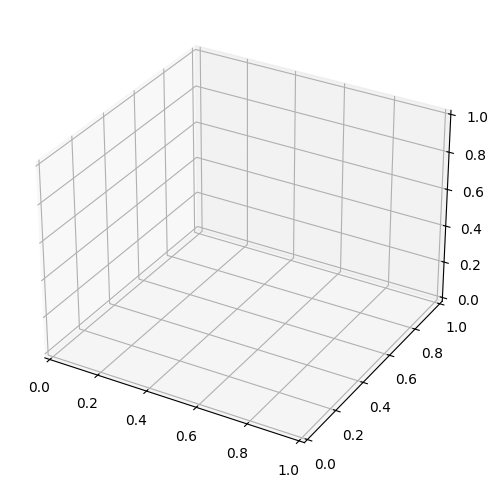

In [38]:
# Plot in 3D
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x_coll.detach().numpy(), y_coll.detach().numpy(), z_coll.detach().numpy(), c='b', marker='o', s=5, alpha=0.6)

# Labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Random Collocation Points')

plt.show()

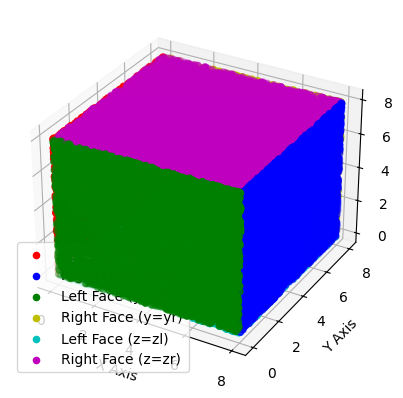

In [11]:
import torch
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D


fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the left and right faces of the cube (along the x-axis)
ax.scatter(x_bc_l.detach().numpy(), y_bc_x.detach().numpy(), z_bc_x.detach().numpy(), c='r', label="Left Face (x=xl)")
ax.scatter(x_bc_r.detach().numpy(), y_bc_x.detach().numpy(), z_bc_x.detach().numpy(), c='b', label="Right Face (x=xr)")

# Plot the left and right faces of the cube (along the y-axis)
ax.scatter(x_bc_y.detach().numpy(), y_bc_l.detach().numpy(), z_bc_y.detach().numpy(), c='g', label="Left Face (y=yl)")
ax.scatter(x_bc_y.detach().numpy(), y_bc_r.detach().numpy(), z_bc_y.detach().numpy(), c='y', label="Right Face (y=yr)")

# Plot the left and right faces of the cube (along the z-axis)
ax.scatter(x_bc_z.detach().numpy(), y_bc_z.detach().numpy(), z_bc_l.detach().numpy(), c='c', label="Left Face (z=zl)")
ax.scatter(x_bc_z.detach().numpy(), y_bc_z.detach().numpy(), z_bc_r.detach().numpy(), c='m', label="Right Face (z=zr)")

# Set labels for the axes
ax.set_xlabel('X Axis')
ax.set_ylabel('Y Axis')
ax.set_zlabel('Z Axis')

# Show legend
ax.legend()

# Show the plot
plt.show()


In [12]:
torch.square(torch.tensor([1.0, 2.0, 6.0]))

tensor([ 1.,  4., 36.])

In [18]:
"""**Neural Newtwork Architecture**"""

class Sin(nn.Module):
    def forward(self, input):
        return torch.sin(input)
class Sin_s(nn.Module):
    def forward(self, input):
        return input*torch.sin(input)
    
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

class PINNs(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(PINNs, self).__init__()


        layers = []
        for i in range(num_layer-1):
            if i == 0:
                layers.append(nn.Linear(in_features=in_dim, out_features=hidden_dim))
                layers.append(Sin())#WaveAct())#Sin())#Sin())
                # layers.append(torch.sin(layers))
            else:
                layers.append(nn.Linear(in_features=hidden_dim, out_features=hidden_dim))
                layers.append(WaveAct())#Sin())

        layers.append(nn.Linear(in_features=hidden_dim, out_features=out_dim))
        #layers.append(Sin_s())#nn.SiLU())

        self.linear = nn.Sequential(*layers)

    def forward(self, x,y,z, t):
        src = torch.cat((x,y,z,t), dim=-1)
        return self.linear(src)
        
class QRes_block(nn.Module):
    def __init__(self, in_dim, out_dim):
        super(QRes_block, self).__init__()
        self.H1 = nn.Linear(in_features=in_dim, out_features=out_dim)
        self.H2 = nn.Linear(in_features=in_dim, out_features=out_dim)
        self.act = WaveAct()#nn.Sigmoid()
    
    def forward(self, x):
        x1 = self.H1(x)
        x2 = self.H2(x)
        return self.act(x1*x2 + x1)



class QRes(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, num_layer):
        super(QRes, self).__init__()
        self.N = num_layer-1
        self.inlayer = QRes_block(in_dim, hidden_dim)
        self.layers = get_clones(QRes_block(hidden_dim, hidden_dim), num_layer-1)
        self.outlayer = nn.Linear(in_features=hidden_dim, out_features=out_dim)

    def forward(self, x,y,z,t):
        src = torch.cat((x,y,z,t), dim=-1)
        src = self.inlayer(src)
        for i in range(self.N):
            src = self.layers[i](src)
        src = self.outlayer(src)
        return src

# Initialize weights using Glorot normal initialization
def init_weights(m):
    if isinstance(m, nn.Linear):
        torch.nn.init.xavier_normal_(m.weight)
        m.bias.data.fill_(0.01)

#net = QRes(in_dim=4, hidden_dim=32, out_dim=3, num_layer=3).to(device)
#net = PINNs(in_dim=4, hidden_dim=32, out_dim=3, num_layer=4).to(device)
net = PINNs(in_dim=4, hidden_dim=16, out_dim=3, num_layer=6).to(device)

net.apply(init_weights) ## This is optional
print(net)

mse_cost_function = torch.nn.MSELoss() # Mean squared error
mae_cost_function = torch.nn.L1Loss() # Mean absolute error
optimizer = torch.optim.Adam(net.parameters(),lr=0.001,)
optimizerL = torch.optim.LBFGS(net.parameters(),line_search_fn='strong_wolfe')

######### Boundary Conditions ##########

def get_boundary_rho_vel_phi(x_bc_l,x_bc_r,y_bc_l,y_bc_r,z_bc_l,z_bc_r,t,net):

    '''
    Estimate the loss at the boundary
    Input: The collocation points at the boundary
           PINN network/model
           Time domain for the time dependent PDEs

    Output:The loss for each of the boudary values
    '''
    #x_boundary, y_boundary, z_boundary
    b_lx,b_ly,b_lz = net(x_bc_l,y_bc_x,z_bc_x,t),net(x_bc_y,y_bc_l,z_bc_y,t),net(x_bc_z,y_bc_z,z_bc_l,t)
    b_rx,b_ry,b_rz = net(x_bc_r,y_bc_x,z_bc_x,t),net(x_bc_y,y_bc_r,z_bc_y,t),net(x_bc_z,y_bc_z,z_bc_r,t)
    #x_boundary, y_boundary, z_boundary
    re_lx,re_ly,re_lz = b_lx[:,0:1],b_ly[:,0:1],b_lz[:,0:1]
    im_lx,im_ly,im_lz = b_lx[:,1:2],b_ly[:,1:2],b_lz[:,1:2]
    V_lx,V_ly,V_lz = b_lx[:,2:3],b_ly[:,2:3],b_lz[:,2:3]

    re_rx,re_ry,re_rz = b_rx[:,0:1],b_ry[:,0:1],b_rz[:,0:1]
    im_rx,im_ry,im_rz = b_rx[:,1:2],b_ry[:,1:2],b_rz[:,1:2]
    V_rx,V_ry,V_rz = b_rx[:,2:3],b_ry[:,2:3],b_rz[:,2:3]
    #     re_lx,re_ly,re_lz = net(x_bc_l,y_bc_x,z_bc_x,t)[:,0:1],net(x_bc_y,y_bc_l,z_bc_y,t)[:,0:1],net(x_bc_z,y_bc_z,z_bc_l,t)[:,0:1]
    #     im_lx,im_ly,im_lz = net(x_bc_l,y_bc_x,z_bc_x,t)[:,1:2],net(x_bc_y,y_bc_l,z_bc_y,t)[:,1:2],net(x_bc_z,y_bc_z,z_bc_l,t)[:,1:2]
    #     V_lx,V_ly,V_lz = net(x_bc_l,y_bc_x,z_bc_x,t)[:,2:3],net(x_bc_y,y_bc_l,z_bc_y,t)[:,2:3],net(x_bc_z,y_bc_z,z_bc_l,t)[:,2:3]

    #     re_rx,re_ry,re_rz = net(x_bc_r,y_bc_x,z_bc_x,t)[:,0:1],net(x_bc_y,y_bc_r,z_bc_y,t)[:,0:1],net(x_bc_z,y_bc_z,z_bc_r,t)[:,0:1]
    #     im_rx,im_ry,im_rz = net(x_bc_r,y_bc_x,z_bc_x,t)[:,1:2],net(x_bc_y,y_bc_r,z_bc_y,t)[:,1:2],net(x_bc_z,y_bc_z,z_bc_r,t)[:,1:2]
    #     V_rx,V_ry,V_rz = net(x_bc_r,y_bc_x,z_bc_x,t)[:,2:3],net(x_bc_y,y_bc_r,z_bc_y,t)[:,2:3],net(x_bc_z,y_bc_z,z_bc_r,t)[:,2:3]


    re_b, im_b, V_b, re_x_b, im_x_b, V_x_b = 0.0,0.0,0.0,0.0,0.0,0.0

    V_l_x = torch.autograd.grad(V_lx, x_bc_l,grad_outputs=torch.ones_like(V_lx), create_graph=True)[0]
    V_r_x = torch.autograd.grad(V_rx, x_bc_r,grad_outputs=torch.ones_like(V_rx), create_graph=True)[0]

    re_l_x = torch.autograd.grad(re_lx, x_bc_l,grad_outputs=torch.ones_like(re_lx), create_graph=True)[0]
    re_r_x = torch.autograd.grad(re_rx, x_bc_r,grad_outputs=torch.ones_like(re_rx), create_graph=True)[0]

    im_l_x = torch.autograd.grad(im_lx, x_bc_l,grad_outputs=torch.ones_like(im_lx), create_graph=True)[0]
    im_r_x = torch.autograd.grad(im_rx, x_bc_r,grad_outputs=torch.ones_like(im_rx), create_graph=True)[0]

    V_l_y = torch.autograd.grad(V_ly, y_bc_l,grad_outputs=torch.ones_like(V_ly), create_graph=True)[0]
    V_r_y = torch.autograd.grad(V_ry, y_bc_r,grad_outputs=torch.ones_like(V_ry), create_graph=True)[0]

    re_l_y = torch.autograd.grad(re_ly, y_bc_l,grad_outputs=torch.ones_like(re_ly), create_graph=True)[0]
    re_r_y = torch.autograd.grad(re_ry, y_bc_r,grad_outputs=torch.ones_like(re_ry), create_graph=True)[0]

    im_l_y = torch.autograd.grad(im_ly, y_bc_l,grad_outputs=torch.ones_like(im_ly), create_graph=True)[0]
    im_r_y = torch.autograd.grad(im_ry, y_bc_r,grad_outputs=torch.ones_like(im_ry), create_graph=True)[0]

    V_l_z = torch.autograd.grad(V_lz, z_bc_l,grad_outputs=torch.ones_like(V_lz), create_graph=True)[0]
    V_r_z = torch.autograd.grad(V_rz, z_bc_r,grad_outputs=torch.ones_like(V_rz), create_graph=True)[0]

    re_l_z = torch.autograd.grad(re_lz, z_bc_l,grad_outputs=torch.ones_like(re_lz), create_graph=True)[0]
    re_r_z = torch.autograd.grad(re_rz, z_bc_r,grad_outputs=torch.ones_like(re_rz), create_graph=True)[0]

    im_l_z = torch.autograd.grad(im_lz, z_bc_l,grad_outputs=torch.ones_like(im_lz), create_graph=True)[0]
    im_r_z = torch.autograd.grad(im_rz, z_bc_r,grad_outputs=torch.ones_like(im_rz), create_graph=True)[0]
    
    #print(V_l_x,V_r_x,re_l_x,re_r_x)
    re_b   += torch.mean((re_lx - re_rx)**2) +torch.mean((re_ly - re_ry)**2) +torch.mean((re_lz - re_rz)**2)
    re_x_b += torch.mean((re_l_x - re_r_x)**2) +  torch.mean((re_l_y - re_r_y)**2) + torch.mean((re_l_z - re_r_z)**2)
    im_b   += torch.mean((im_lx - im_rx)**2) + torch.mean((im_ly - im_ry)**2) + torch.mean((im_lz - im_rz)**2)
    im_x_b += torch.mean((im_l_x - im_r_x)**2) + torch.mean((im_l_y - im_r_y)**2) + torch.mean((im_l_z - im_r_z)**2)
    V_b    += torch.mean((V_lx - V_rx)**2)+ torch.mean((V_ly - V_ry)**2)+ torch.mean((V_lz - V_rz)**2)
    V_x_b  += torch.mean((V_l_x - V_r_x)**2) + torch.mean((V_l_y - V_r_y)**2) + torch.mean((V_l_z - V_r_z)**2)

    # re_bx, re_by, re_bz = (re_lx - re_rx),(re_ly - re_ry),(re_lz - re_rz)
    # re_x_bx, re_x_by, re_x_bz = (re_l_x - re_r_x), (re_l_y - re_r_y), (re_l_z - re_r_z)
    # im_bx, im_by, im_bz = (im_lx - im_rx), (im_ly - im_ry), (im_lz - im_rz)
    # im_x_bx, im_x_by, im_x_bz = (im_l_x - im_r_x), (im_l_y - im_r_y), (im_l_z - im_r_z)
    # V_bx, V_by, V_bz = (V_lx - V_rx), (V_ly - V_ry), (V_lz - V_rz)
    # V_x_bx, V_x_by, V_x_bz = (V_l_x - V_r_x), (V_l_y - V_r_y), (V_l_z - V_r_z)
    #print(re_b,re_x_b,im_b,im_x_b,V_b,V_x_b)
    
    return re_b, im_b, V_b , V_x_b, re_x_b, im_x_b
    #return re_bx,re_by,re_bz,re_x_bx,re_x_by, re_x_bz,im_bx, im_by, im_bz,im_x_bx, im_x_by, im_x_bz,V_bx, V_by, V_bz,V_x_bx, V_x_by, V_x_bz




######### Residue from the PDEs##########

def pde_residue(x,y,z,t,net):

    '''
    This is the main function that returns all the PDE residue
    INPUT: x and t collocation points for the 1D problem
    OUTPUT: The output dimension is 3, one of density, one for velocity and finally for phi
    '''

    sol = net(x,y,z,t)
    #print(sol.shape)
    # re = net(x,y,z,t)[:,0:1]
    # im = net(x,y,z,t)[:,1:2]
    # V = net(x,y,z,t)[:,2:3]
    re, im, V = sol[:,0:1],sol[:,1:2],sol[:,2:3]
    #print(re.shape,x.shape)
    ## Derivatives for the Equations:
    re_x = torch.autograd.grad(re, x,grad_outputs=torch.ones_like(re), create_graph=True)[0]
    re_xx = torch.autograd.grad(re_x, x,grad_outputs=torch.ones_like(re_x), create_graph=True)[0]
    re_y = torch.autograd.grad(re, y,grad_outputs=torch.ones_like(re), create_graph=True)[0]
    re_yy = torch.autograd.grad(re_y, y,grad_outputs=torch.ones_like(re_y), create_graph=True)[0]
    re_z = torch.autograd.grad(re, z,grad_outputs=torch.ones_like(re), create_graph=True)[0]
    re_zz = torch.autograd.grad(re_z, z,grad_outputs=torch.ones_like(re_z), create_graph=True)[0]
    re_t = torch.autograd.grad(re, t,grad_outputs=torch.ones_like(re),create_graph=True)[0]

    im_x = torch.autograd.grad(im, x,grad_outputs=torch.ones_like(im), create_graph=True)[0]
    im_xx = torch.autograd.grad(im_x, x,grad_outputs=torch.ones_like(im_x), create_graph=True)[0]
    im_y = torch.autograd.grad(im, y,grad_outputs=torch.ones_like(im), create_graph=True)[0]
    im_yy = torch.autograd.grad(im_y, y,grad_outputs=torch.ones_like(im_y), create_graph=True)[0]
    im_z = torch.autograd.grad(im, z,grad_outputs=torch.ones_like(im), create_graph=True)[0]
    im_zz = torch.autograd.grad(im_z, z,grad_outputs=torch.ones_like(im_z), create_graph=True)[0]
    im_t = torch.autograd.grad(im, t,grad_outputs=torch.ones_like(im), create_graph=True)[0]

    V_x = torch.autograd.grad(V, x,grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_xx = torch.autograd.grad(V_x, x,grad_outputs=torch.ones_like(V_x), create_graph=True)[0]
    V_y = torch.autograd.grad(V, y,grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_yy = torch.autograd.grad(V_y, y,grad_outputs=torch.ones_like(V_y), create_graph=True)[0]
    V_z = torch.autograd.grad(V, z,grad_outputs=torch.ones_like(V), create_graph=True)[0]
    V_zz = torch.autograd.grad(V_z, z,grad_outputs=torch.ones_like(V_z), create_graph=True)[0]

    re_r =re_t  +  0.5 * (im_xx + im_yy + im_zz) - V * im
    im_r = im_t - 0.5 * (re_xx + re_yy + re_zz) + V * re
    V_r = (V_xx + V_yy + V_zz) - ((re**2+im**2)-1.0)
    return re_r,im_r,V_r

PINNs(
  (linear): Sequential(
    (0): Linear(in_features=4, out_features=16, bias=True)
    (1): Sin()
    (2): Linear(in_features=16, out_features=16, bias=True)
    (3): WaveAct()
    (4): Linear(in_features=16, out_features=16, bias=True)
    (5): WaveAct()
    (6): Linear(in_features=16, out_features=16, bias=True)
    (7): WaveAct()
    (8): Linear(in_features=16, out_features=16, bias=True)
    (9): WaveAct()
    (10): Linear(in_features=16, out_features=3, bias=True)
  )
)


In [41]:
psi_re_0 = psi(x_init,y_init,z_init,t_init)[:,0:1]
psi_im_0 = psi(x_init,y_init,z_init,t_init)[:,1:2]

torch.Size([6300, 1])
torch.Size([6300, 1])
torch.Size([6300, 1])
torch.Size([6300, 1])


In [42]:
psi_re_0

tensor([[0.9354],
        [1.1068],
        [1.0369],
        ...,
        [0.9665],
        [0.9555],
        [1.0002]], device='mps:0')

In [43]:
net(x_init,y_init,z_init,t_init)

tensor([[-0.0198, -3.8356, -0.6211],
        [ 0.4691, -3.2668, -0.7590],
        [ 0.4637, -2.6851,  0.1535],
        ...,
        [ 0.6826, -3.1693, -0.2067],
        [-0.0305, -3.8056, -0.5584],
        [ 0.4971, -2.4894,  0.3450]], device='mps:0',
       grad_fn=<LinearBackward0>)

In [44]:
from tqdm import tqdm
import time
iterations = 200
start = time.time()
def closure():

        ############## Loss based on initial conditions ###############

        net_ic_out = net(x_init,y_init,z_init,t_init)
        re_ic_out = net_ic_out[:,0:1]
        im_ic_out = net_ic_out[:,1:2]

        mse_re_ic =  mse_cost_function(re_ic_out, psi_re_0)#get_real(psi(x_initial,t_initial)))
        mse_im_ic =  mse_cost_function(im_ic_out, psi_im_0)#get_imag(psi(x_initial,t_initial)))

        ############# Loss based on boundary conditions #################
        #x_l_list = torch.cat([xx_l,yy_l,zz_l],dim = 1)
        #x_r_list = torch.cat([xx_r,yy_r,zz_r],dim = 1)
        #print(x_l_list.shape)
        re_b, im_b, V_b, V_x_b, re_x_b, im_x_b = get_boundary_rho_vel_phi(x_bc_l,x_bc_r,y_bc_l,y_bc_r,z_bc_l,z_bc_r,t_boundary,net) # output of u(x,t)

        #re_bx,re_by,re_bz,re_x_bx,re_x_by, re_x_bz,im_bx, im_by, im_bz,im_x_bx, im_x_by, im_x_bz,V_bx, V_by, V_bz,V_x_bx, V_x_by, V_x_bz= get_boundary_rho_vel_phi(x_bc_l,x_bc_r,y_bc_l,y_bc_r,z_bc_l,z_bc_r,t_boundary,net) # output of u(x,t)

        mse_bc_re = re_b#torch.mean(re_b ) ## mse_cost_function(rho_bc_out,pt_all_zeros_bc)
        mse_bc_im = im_b#torch.mean(im_b ) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_V = V_b#torch.mean(V_b ) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_V_x = V_x_b#torch.mean(V_x_b ) ## mse_cost_function(vel_bc_out,pt_all_zeros_bc)
        mse_bc_re_x = re_x_b#torch.mean(re_x_b )
        mse_bc_im_x = im_x_b#torch.mean(im_x_b )
        
        # mse_bc1, mse_bc2, mse_bc3 = torch.mean(re_bx**2),torch.mean(re_by**2),torch.mean(re_bz**2)
        # mse_bc4, mse_bc5, mse_bc6 = torch.mean(re_x_bx**2),torch.mean(re_x_by**2),torch.mean(re_x_bz**2)
        # mse_bc7, mse_bc8, mse_bc9 = torch.mean(im_bx**2),torch.mean(im_by**2),torch.mean(im_bz**2)
        # mse_bc10, mse_bc11, mse_bc12 = torch.mean(im_x_bx**2),torch.mean(im_x_by**2),torch.mean(im_x_bz**2)
        # mse_bc13, mse_bc14, mse_bc15 = torch.mean(V_bx**2),torch.mean(V_by**2),torch.mean(V_bz**2)
        # mse_bc16, mse_bc17, mse_bc18 = torch.mean(V_x_bx**2),torch.mean(V_x_by**2),torch.mean(V_x_bz**2)

        ############## Loss based on PDE ###################################
        
        #x_c_list = torch.cat([xx_c,yy_c,zz_c],dim = 1)
        re_r,im_r,V_r = pde_residue(x_coll, y_coll, z_coll, t_coll, net) # output of rho(x,t) and vel(x,t)


        mse_re = torch.mean(re_r ** 2)  ##mse_cost_function(rho_pde_out, pt_all_zeros)
        mse_im = torch.mean(im_r ** 2)  ## mse_cost_function(vel_pde_out, pt_all_zeros)
        mse_V = torch.mean(V_r ** 2)  ## mse_cost_function(vel_pde_out, pt_all_zeros)
        #mse_rho = torch.mean(rho_r ** 2)


        ################### Combining the loss functions ####################
        loss = mse_re_ic + mse_im_ic + mse_re + mse_im +mse_V + mse_bc_re+ mse_bc_im + mse_bc_V+ mse_bc_V_x + mse_bc_re_x + mse_bc_im_x
        #loss = mse_re_ic + mse_im_ic + mse_re + mse_im +mse_V+ mse_bc1 + mse_bc2 + mse_bc3 + mse_bc4 + mse_bc5 + mse_bc6 +mse_bc7 + mse_bc8 + mse_bc9 + mse_bc10 + mse_bc11 + mse_bc12 +mse_bc11 + mse_bc12 + mse_bc13 + mse_bc14 + mse_bc15 + mse_bc16 +  mse_bc17 + mse_bc18
        # if i%50==0:
        #     # ic_loss.append(mse_re_ic+mse_im_ic)
        #     pde_loss.append(mse_re+mse_im+mse_V)
        #mse_V + mse_bc_re+ mse_bc_im + mse_bc_V+ mse_bc_V_x + mse_bc_re_x + mse_bc_im_x
        ################### Combining the loss functions ####################
        # Stack all loss terms
        #         loss_terms = torch.stack([
        #             mse_re_ic, mse_im_ic, mse_re, mse_im, mse_V,
        #             mse_bc_re, mse_bc_im, mse_bc_V, mse_bc_V_x
        #         ])

        #         # Normalize weights using softmax to ensure they sum to 1
        #         normalized_weights = torch.nn.functional.softmax(loss_weights, dim=0)

        #         # Compute weighted loss
        #         loss = torch.sum(normalized_weights * loss_terms)

        optimizerL.zero_grad()
        loss.backward() # This is for computing gradients using backward propagationerivative of J w.r.t theta
        return loss
TOTAL_loss = []
# ic_loss = []
#pde_loss = []
## Using ADAM

for i in tqdm(range(iterations)):
    loss_ = optimizer.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
print("INFO:Adam training done LBFGS initiated")
# Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations*3)):
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

# # torch.save(net.state_dict(), 'PINN3.pt')


  1%|▍                                          | 2/200 [00:00<00:25,  7.70it/s]

TOTAL LOSS =9.73e+01


 26%|██████████▉                               | 52/200 [00:05<00:15,  9.33it/s]

TOTAL LOSS =1.26e+00


 51%|████████████████████▉                    | 102/200 [00:11<00:10,  9.21it/s]

TOTAL LOSS =5.10e-01


 76%|███████████████████████████████▏         | 152/200 [00:16<00:05,  8.92it/s]

TOTAL LOSS =3.21e-01


100%|█████████████████████████████████████████| 200/200 [00:22<00:00,  9.07it/s]


INFO:Adam training done LBFGS initiated


  0%|                                           | 1/600 [00:02<24:57,  2.50s/it]

TOTAL LOSS =2.31e-01


  8%|███▌                                      | 51/600 [02:40<29:59,  3.28s/it]

TOTAL LOSS =3.50e-04


 17%|██████▉                                  | 101/600 [05:19<26:04,  3.14s/it]

TOTAL LOSS =2.10e-04


 25%|██████████▎                              | 151/600 [07:57<23:29,  3.14s/it]

TOTAL LOSS =1.15e-04


 34%|█████████████▋                           | 201/600 [10:33<20:36,  3.10s/it]

TOTAL LOSS =8.64e-05


 42%|█████████████████▏                       | 251/600 [13:13<18:28,  3.18s/it]

TOTAL LOSS =7.22e-05


 50%|████████████████████▌                    | 301/600 [15:52<15:28,  3.11s/it]

TOTAL LOSS =6.21e-05


 58%|███████████████████████▉                 | 351/600 [18:33<13:11,  3.18s/it]

TOTAL LOSS =5.41e-05


 59%|████████████████████████                 | 352/600 [18:38<13:07,  3.18s/it]


KeyboardInterrupt: 

In [15]:
torch.load

<function torch.serialization.load(f: Union[str, os.PathLike, BinaryIO, IO[bytes]], map_location: Union[Callable[[torch.types.Storage, str], torch.types.Storage], torch.device, str, Dict[str, str], NoneType] = None, pickle_module: Any = None, *, weights_only: Optional[bool] = None, mmap: Optional[bool] = None, **pickle_load_args: Any) -> Any>

In [15]:
net.load_state_dict(torch.load('PINN3D_4L_32.pt'))

/var/folders/1z/7szzkg216zx__vgx8p4vkt_h0000gp/T/ipykernel_3645/197099627.py:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('PINN3D_qres.pt'

<All keys matched successfully>

In [57]:
torch.save(net.state_dict(), 'PINN3D_4L_32.pt')

In [51]:
# Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations*2)):
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  0%|                                           | 1/400 [00:03<21:45,  3.27s/it]

TOTAL LOSS =5.38e-05


 13%|█████▎                                    | 51/400 [02:31<13:32,  2.33s/it]

TOTAL LOSS =4.93e-05


 26%|██████████▍                              | 102/400 [04:25<01:27,  3.40it/s]

TOTAL LOSS =4.70e-05


 38%|███████████████▌                         | 152/400 [04:32<00:36,  6.83it/s]

TOTAL LOSS =4.70e-05


 50%|████████████████████▋                    | 202/400 [04:39<00:29,  6.75it/s]

TOTAL LOSS =4.70e-05


 63%|█████████████████████████▊               | 252/400 [04:47<00:22,  6.62it/s]

TOTAL LOSS =4.70e-05


 76%|██████████████████████████████▉          | 302/400 [04:54<00:14,  6.62it/s]

TOTAL LOSS =4.70e-05


 88%|████████████████████████████████████     | 352/400 [05:02<00:06,  6.97it/s]

TOTAL LOSS =4.70e-05


100%|█████████████████████████████████████████| 400/400 [05:09<00:00,  1.29it/s]

Total time = 1567.025800228119 sec 


In [27]:
# Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations*2)):
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  0%|          | 1/400 [00:01<12:42,  1.91s/it]

TOTAL LOSS =1.56e-04


 13%|█▎        | 51/400 [01:31<10:41,  1.84s/it]

TOTAL LOSS =1.52e-04


 25%|██▌       | 101/400 [03:03<09:22,  1.88s/it]

TOTAL LOSS =1.47e-04


 38%|███▊      | 151/400 [04:33<07:41,  1.85s/it]

TOTAL LOSS =1.42e-04


 50%|█████     | 201/400 [06:03<06:01,  1.82s/it]

TOTAL LOSS =1.37e-04


 63%|██████▎   | 251/400 [07:36<04:19,  1.74s/it]

TOTAL LOSS =1.32e-04


 75%|███████▌  | 301/400 [09:05<02:55,  1.77s/it]

TOTAL LOSS =1.28e-04


 88%|████████▊ | 352/400 [10:16<00:08,  5.64it/s]

TOTAL LOSS =1.25e-04


100%|██████████| 400/400 [10:20<00:00,  1.55s/it]

Total time = 2802.0612695217133 sec 


In [29]:
# Using LBFGS after the initial ADAM training
for i in tqdm(range(iterations*2)):
    loss_ = optimizerL.step(closure)
    TOTAL_loss.append(loss_.item())
    if i % 50 == 0:
        print("TOTAL LOSS ={:.2e}".format(loss_.item()))
end = time.time()
print("Total time = {} sec ".format(end - start))

  0%|          | 2/400 [00:00<00:36, 11.00it/s]

TOTAL LOSS =1.25e-04


 13%|█▎        | 52/400 [00:04<00:29, 11.69it/s]

TOTAL LOSS =1.25e-04


 26%|██▌       | 102/400 [00:08<00:25, 11.64it/s]

TOTAL LOSS =1.25e-04


 38%|███▊      | 152/400 [00:13<00:21, 11.42it/s]

TOTAL LOSS =1.25e-04


 50%|█████     | 202/400 [00:17<00:16, 11.70it/s]

TOTAL LOSS =1.25e-04


 63%|██████▎   | 252/400 [00:21<00:12, 11.68it/s]

TOTAL LOSS =1.25e-04


 76%|███████▌  | 302/400 [00:25<00:08, 11.69it/s]

TOTAL LOSS =1.25e-04


 88%|████████▊ | 352/400 [00:30<00:04, 11.64it/s]

TOTAL LOSS =1.25e-04


100%|██████████| 400/400 [00:34<00:00, 11.63it/s]

Total time = 2909.85129404068 sec 


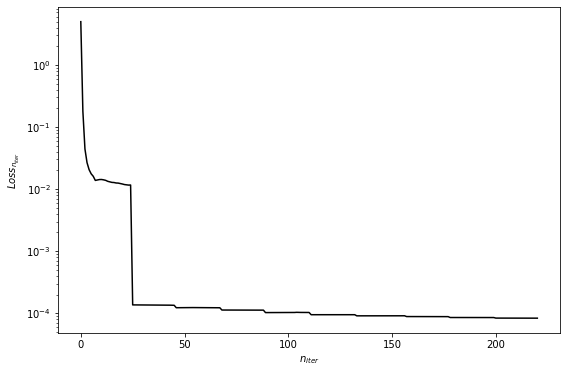

In [31]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
# hist =[] is used for storing losses during training
i1 =[i.detach().numpy() for i in ic_loss]
hist = i1#TOTAL_loss#_history
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{iter}$')
ax.set_ylabel('$Loss_{n_{iter}}$');

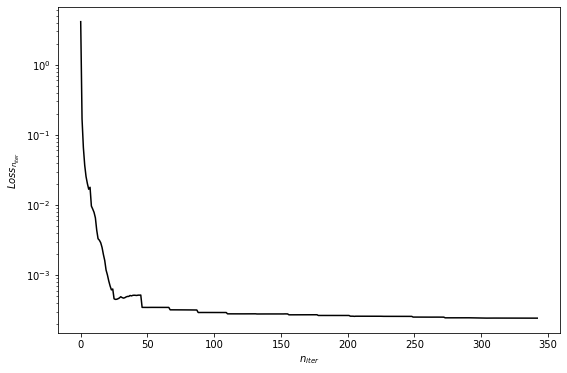

In [70]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
# hist =[] is used for storing losses during training
#pde_loss1 = pde_loss.cpu()
i1 =[(i.cpu()).detach().numpy() for i in pde_loss]
hist = i1#TOTAL_loss#_history
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{iter}$')
ax.set_ylabel('$Loss_{n_{iter}}$');

In [59]:
torch.save(net.state_dict(), 'PINN3D_qres.pt')


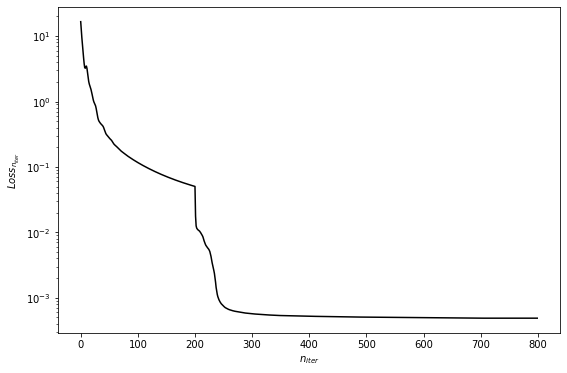

In [26]:
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
# hist =[] is used for storing losses during training
#i1 =[i.detach().numpy() for i in pde_loss]
hist = TOTAL_loss#_history
ax.semilogy(range(len(hist)), hist,'k-')
ax.set_xlabel('$n_{iter}$')
ax.set_ylabel('$Loss_{n_{iter}}$');

In [34]:
device = torch.device('cpu')
net.to(device)

QRes(
  (inlayer): QRes_block(
    (H1): Linear(in_features=4, out_features=256, bias=True)
    (H2): Linear(in_features=4, out_features=256, bias=True)
    (act): WaveAct()
  )
  (layers): ModuleList(
    (0-2): 3 x QRes_block(
      (H1): Linear(in_features=256, out_features=256, bias=True)
      (H2): Linear(in_features=256, out_features=256, bias=True)
      (act): WaveAct()
    )
  )
  (outlayer): Linear(in_features=256, out_features=3, bias=True)
)

In [13]:
dx = 8./150.#0.01    # Spatial resolution
dt = np.pi/100#0.04   # Time step
L = 8.0    # Length of the 1D box
N = int(L / dx)  # Numb"er of grid points
x = torch.linspace(0,L,N).to(device)#np.linspace(-L/2, L/2, N)  # Spatial grid
y = torch.linspace(0,L,N).to(device)
z = torch.linspace(0,L,N).to(device)
xx, yy, zz = torch.meshgrid(x,y,z, indexing = 'ij')

In [14]:
xx.shape

torch.Size([150, 150, 150])

In [15]:
150**3

3375000

/var/folders/1z/7szzkg216zx__vgx8p4vkt_h0000gp/T/ipykernel_3099/2290267742.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('PINN3D_4L_32.p

tensor(3374260.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3374970.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3374693.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3374018.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3373374., device='mps:0', grad_fn=<SumBackward0>)
tensor(3372984.2500, device='mps:0', grad_fn=<SumBackward0>)
tensor(3372873.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3372916., device='mps:0', grad_fn=<SumBackward0>)
tensor(3372918.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3372701.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3372167.2500, device='mps:0', grad_fn=<SumBackward0>)
tensor(3371328., device='mps:0', grad_fn=<SumBackward0>)
tensor(3370295., device='mps:0', grad_fn=<SumBackward0>)
tensor(3369237.7500, device='mps:0', grad_fn=<SumBackward0>)
tensor(3368309.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3367585., device='mps:0', grad_fn=<SumBackward0>)
tensor(3367017., device='mps:0', grad_fn=<Su

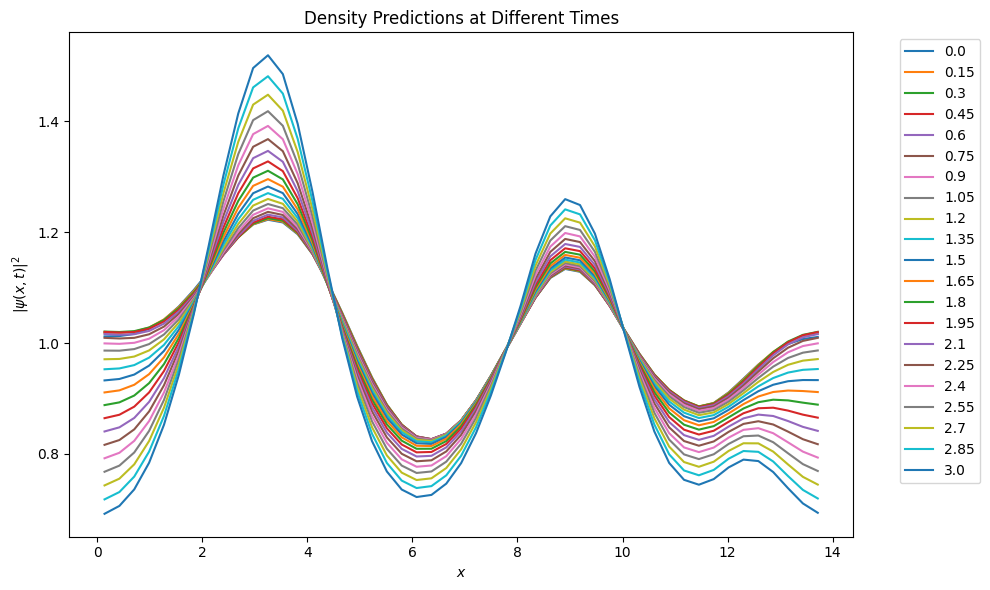

In [17]:
#model = score_model_cond()
net.load_state_dict(torch.load('PINN3D_4L_32.pt'))

# Define the time points we want to plot
time_indices = [i / 100 for i in range(0,314, 15)]  # Time points to visualize

# Set up the figure
fig = plt.figure(figsize=(10, 6))
plt.title('Density Predictions at Different Times')
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t)|^2$')

# Use a colormap for the rainbow effect
cmap = plt.cm.rainbow
colors = cmap(np.linspace(0, 1, len(time_indices)))

# Loop over selected time points and plot each density profile
for idx, color in zip(time_indices, colors):
    #print(idx)
    # Update time value for current plot
    t_1 = torch.ones((3375000,1)).to(device) * idx#0.0
    x_1 = xx.ravel().reshape((3375000,1))#x_init#torch.rand((25*3,1)) * (8.0 - 0.0)  # Adjust xl and xr as needed
    y_1 = yy.ravel().reshape((3375000,1))#y_init#torch.rand((25*3,1)) * (8.0 - 0.0)
    z_1 =zz.ravel().reshape((3375000,1))#z_init#torch.rand((25*3,1)) * (8.0 - 0.0)
    #xx_1, yy_1, zz_1 = torch.meshgrid(x_1,x_1,x_1,indexing = 'ij')
    #xx_1, yy_1, zz_1 = xx_1.flatten().unsqueeze(-1),yy_1.flatten().unsqueeze(-1), zz_1.flatten().unsqueeze(-1)
    #xt_1 = torch.cat([x_1, t_1], dim=1)
    
    # Predict density at the current time
    psi_collocation_pred = net(x_1,y_1,z_1,t_1)#net(x_1[:,None,None,None], x_1[None,:,None,None],x_1[None,None,:,None],t_1[None,None,None,:])[:,0:2]#net(xx_1,yy_1,zz_1,t_1)[:,0:2]  # Assuming `model` outputs both real and imag
    #print(psi_collocation_pred.shape)
    
    density_pred =psi_collocation_pred[:,0]**2 + psi_collocation_pred[:,1]**2#get_density(psi_collocation_pred)
    #print(len(x_1))
    #print(len(density_pred))
    #print(psi_collocation_pred.shape)
    print(torch.sum(density_pred))
    # Plot the density for the current time
    # plt.s(
    #     x_1.detach().numpy(),
    #     density_pred.detach().numpy(),
    #     color=color,
    #     marker='X',
    #     label=f"$t = {idx:.2f}$"
    # )
    #print(density_pred.shape)
    #plt.imshow(density_pred[:,:,5].detach().numpy())
    #plt.show()
    # Flatten the arrays to 1D for binning
    r_flat = (torch.sqrt(x_1**2+y_1**2+z_1**2)).flatten()

    density_flat = density_pred.flatten()

    # Define the number of bins for the radial distances
    num_bins = 50
    r_bins = torch.linspace(torch.min(r_flat), torch.max(r_flat), num_bins)

    # Compute the average density in each bin
    avg_density = np.zeros(num_bins - 1)

    for i in range(num_bins - 1):
        # Find the indices of r values within the current bin range
        bin_indices = (r_flat >= r_bins[i]) & (r_flat < r_bins[i + 1])

        # Average density in the bin
        avg_density[i] = torch.mean(density_flat[bin_indices])

    # Plot the density as a function of radius
    plt.plot(r_bins[:-1] + np.diff(r_bins) / 2, avg_density,label= idx)  # Plot the center of each bin
    #print(np.sum(density_flat))
    #plt.xlabel('Radius')
    #plt.ylabel('Density')
    #plt.title('Density as a function of Radius')
    #plt.grid(True)
    #plt.show()
# Add legend and show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cuda:0 and cpu! (when checking argument for argument tensors in method wrapper___cat)

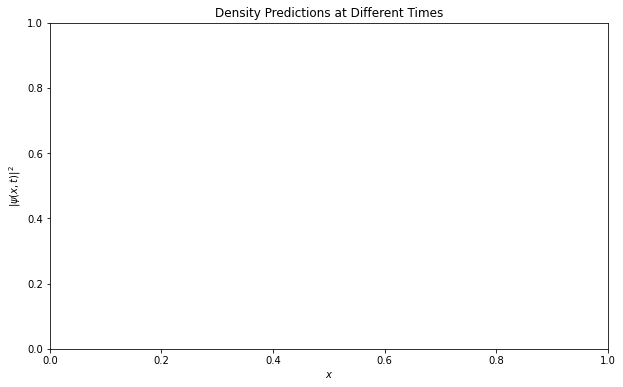

In [23]:
#model = score_model_cond()
#net.load_state_dict(torch.load('PINN2.pt'))

# Define the time points we want to plot
time_indices = [i / 100 for i in range(0,314, 25)]  # Time points to visualize

# Set up the figure
fig = plt.figure(figsize=(10, 6))
plt.title('Density Predictions at Different Times')
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t)|^2$')

# Use a colormap for the rainbow effect
cmap = plt.cm.rainbow
colors = cmap(np.linspace(0, 1, len(time_indices)))

# Loop over selected time points and plot each density profile
for idx, color in zip(time_indices, colors):
    #print(idx)
    # Update time value for current plot
    t_1 = torch.ones((3375000,1)) * 0.0
    x_1 = xx.ravel().reshape((3375000,1))#x_init#torch.rand((25*3,1)) * (8.0 - 0.0)  # Adjust xl and xr as needed
    y_1 = yy.ravel().reshape((3375000,1))#y_init#torch.rand((25*3,1)) * (8.0 - 0.0)
    z_1 =zz.ravel().reshape((3375000,1))#z_init#torch.rand((25*3,1)) * (8.0 - 0.0)
    #xx_1, yy_1, zz_1 = torch.meshgrid(x_1,x_1,x_1,indexing = 'ij')
    #xx_1, yy_1, zz_1 = xx_1.flatten().unsqueeze(-1),yy_1.flatten().unsqueeze(-1), zz_1.flatten().unsqueeze(-1)
    #xt_1 = torch.cat([x_1, t_1], dim=1)
    
    # Predict density at the current time
    psi_collocation_pred = net(x_1,y_1,z_1,t_1)#net(x_1[:,None,None,None], x_1[None,:,None,None],x_1[None,None,:,None],t_1[None,None,None,:])[:,0:2]#net(xx_1,yy_1,zz_1,t_1)[:,0:2]  # Assuming `model` outputs both real and imag
    #print(psi_collocation_pred.shape)
    
    density_pred =psi_collocation_pred[:,0]**2 + psi_collocation_pred[:,1]**2#get_density(psi_collocation_pred)
    #print(len(x_1))
    #print(len(density_pred))
    #print(psi_collocation_pred.shape)
    print(torch.sum(density_pred))
    # Plot the density for the current time
    # plt.s(
    #     x_1.detach().numpy(),
    #     density_pred.detach().numpy(),
    #     color=color,
    #     marker='X',
    #     label=f"$t = {idx:.2f}$"
    # )
    #print(density_pred.shape)
    #plt.imshow(density_pred[:,:,5].detach().numpy())
    #plt.show()
    # Flatten the arrays to 1D for binning
    r_flat = (np.sqrt(x_1**2+y_1**2+z_1**2)).flatten()
    
    density_flat = (psi_re_0**2 + psi_im_0**2).flatten()#density_pred.flatten()
    print(density_flat.shape)
    # Define the number of bins for the radial distances
    num_bins = 50
    r_bins = np.linspace(torch.min(r_flat), torch.max(r_flat), num_bins)

    # Compute the average density in each bin
    avg_density = np.zeros(num_bins - 1)

    for i in range(num_bins - 1):
        # Find the indices of r values within the current bin range
        bin_indices = (r_flat >= r_bins[i]) & (r_flat < r_bins[i + 1])

        # Average density in the bin
        avg_density[i] = torch.mean(density_flat[bin_indices])

    # Plot the density as a function of radius
    plt.plot(r_bins[:-1] + np.diff(r_bins) / 2, avg_density,label= idx)  # Plot the center of each bin
    #print(np.sum(density_flat))
    #plt.xlabel('Radius')
    #plt.ylabel('Density')
    #plt.title('Density as a function of Radius')
    #plt.grid(True)
    #plt.show()
# Add legend and show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [9]:
class WaveAct(nn.Module):
    def __init__(self):
        super(WaveAct, self).__init__() 
        self.w1 = nn.Parameter(torch.ones(1), requires_grad=True)
        self.w2 = nn.Parameter(torch.ones(1), requires_grad=True)

    def forward(self, x):
        return self.w1 * torch.sin(x)+ self.w2 * torch.cos(x)

In [10]:
import copy
def get_clones(module, num_of_deep_copies):
    # Create deep copies so that we can tweak each module's weights independently
    return nn.ModuleList([copy.deepcopy(module) for _ in range(num_of_deep_copies)])

In [31]:
import os
os.environ['PYTORCH_MPS_HIGH_WATERMARK_RATIO'] = '0.0'

/var/folders/1z/7szzkg216zx__vgx8p4vkt_h0000gp/T/ipykernel_3099/3543923506.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  net.load_state_dict(torch.load('PINN3D_6L_16.p

tensor(3374794., device='mps:0', grad_fn=<SumBackward0>)
tensor(3375329.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3374958.2500, device='mps:0', grad_fn=<SumBackward0>)
tensor(3374232.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3373518., device='mps:0', grad_fn=<SumBackward0>)
tensor(3373018., device='mps:0', grad_fn=<SumBackward0>)
tensor(3372807.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3372862.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3373100., device='mps:0', grad_fn=<SumBackward0>)
tensor(3373404., device='mps:0', grad_fn=<SumBackward0>)
tensor(3373657.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3373759.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3373642., device='mps:0', grad_fn=<SumBackward0>)
tensor(3373277.5000, device='mps:0', grad_fn=<SumBackward0>)
tensor(3372679., device='mps:0', grad_fn=<SumBackward0>)
tensor(3371897., device='mps:0', grad_fn=<SumBackward0>)
tensor(3371009.5000, device='mps:0', grad_fn=<SumBackwar

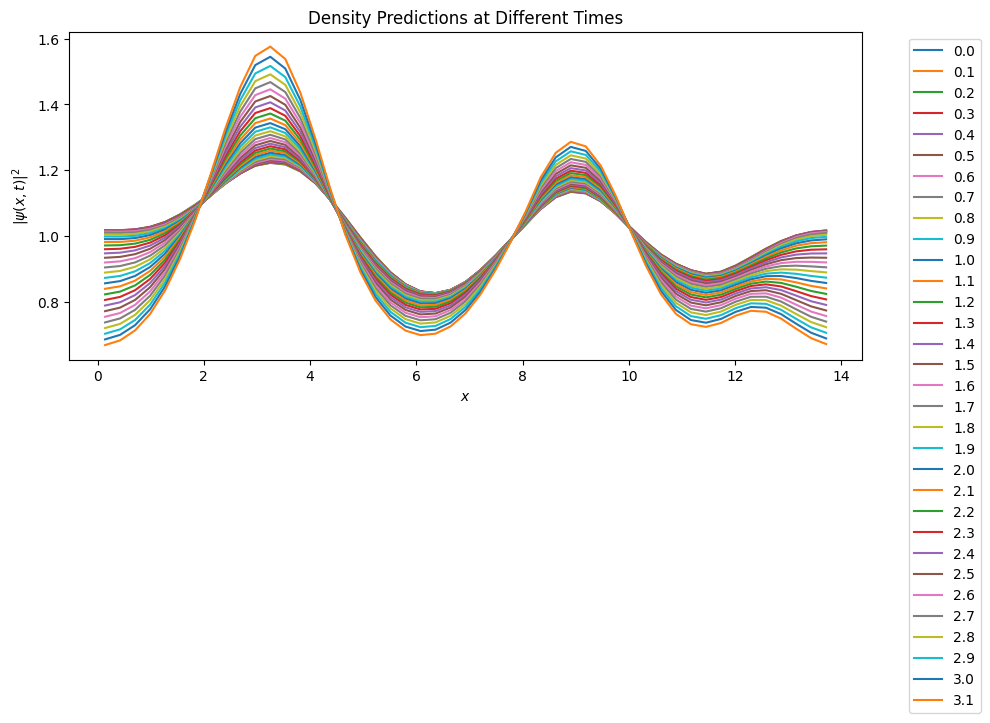

In [20]:
#model = score_model_cond()
net.load_state_dict(torch.load('PINN3D_6L_16.pt'))

# Define the time points we want to plot
time_indices = [i / 100 for i in range(0,314, 10)]  # Time points to visualize

# Set up the figure
fig = plt.figure(figsize=(10, 6))
plt.title('Density Predictions at Different Times')
plt.xlabel('$x$')
plt.ylabel('$|\psi(x, t)|^2$')

# Use a colormap for the rainbow effect
cmap = plt.cm.rainbow
colors = cmap(np.linspace(0, 1, len(time_indices)))

# Loop over selected time points and plot each density profile
for idx, color in zip(time_indices, colors):
    #print(idx)
    # Update time value for current plot
    t_1 = torch.ones((3375000,1)).to(device) * idx#0.0
    x_1 = xx.ravel().reshape((3375000,1))#x_init#torch.rand((25*3,1)) * (8.0 - 0.0)  # Adjust xl and xr as needed
    y_1 = yy.ravel().reshape((3375000,1))#y_init#torch.rand((25*3,1)) * (8.0 - 0.0)
    z_1 =zz.ravel().reshape((3375000,1))#z_init#torch.rand((25*3,1)) * (8.0 - 0.0)
    #xx_1, yy_1, zz_1 = torch.meshgrid(x_1,x_1,x_1,indexing = 'ij')
    #xx_1, yy_1, zz_1 = xx_1.flatten().unsqueeze(-1),yy_1.flatten().unsqueeze(-1), zz_1.flatten().unsqueeze(-1)
    #xt_1 = torch.cat([x_1, t_1], dim=1)
    
    # Predict density at the current time
    psi_collocation_pred = net(x_1,y_1,z_1,t_1)#net(x_1[:,None,None,None], x_1[None,:,None,None],x_1[None,None,:,None],t_1[None,None,None,:])[:,0:2]#net(xx_1,yy_1,zz_1,t_1)[:,0:2]  # Assuming `model` outputs both real and imag
    #print(psi_collocation_pred.shape)
    
    density_pred =psi_collocation_pred[:,0]**2 + psi_collocation_pred[:,1]**2#get_density(psi_collocation_pred)
    #print(len(x_1))
    #print(len(density_pred))
    #print(psi_collocation_pred.shape)
    print(torch.sum(density_pred))
    # Plot the density for the current time
    # plt.s(
    #     x_1.detach().numpy(),
    #     density_pred.detach().numpy(),
    #     color=color,
    #     marker='X',
    #     label=f"$t = {idx:.2f}$"
    # )
    #print(density_pred.shape)
    #plt.imshow(density_pred[:,:,5].detach().numpy())
    #plt.show()
    # Flatten the arrays to 1D for binning
    r_flat = (torch.sqrt(x_1**2+y_1**2+z_1**2)).flatten()

    density_flat = density_pred.flatten()

    # Define the number of bins for the radial distances
    num_bins = 50
    r_bins = torch.linspace(torch.min(r_flat), torch.max(r_flat), num_bins)

    # Compute the average density in each bin
    avg_density = np.zeros(num_bins - 1)

    for i in range(num_bins - 1):
        # Find the indices of r values within the current bin range
        bin_indices = (r_flat >= r_bins[i]) & (r_flat < r_bins[i + 1])

        # Average density in the bin
        avg_density[i] = torch.mean(density_flat[bin_indices])

    # Plot the density as a function of radius
    plt.plot(r_bins[:-1] + np.diff(r_bins) / 2, avg_density,label= idx)  # Plot the center of each bin
    #print(np.sum(density_flat))
    #plt.xlabel('Radius')
    #plt.ylabel('Density')
    #plt.title('Density as a function of Radius')
    #plt.grid(True)
    #plt.show()
# Add legend and show plot
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()
